In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words= open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


**Building the dataset**

In [5]:
block_size= 3 #input size
X,Y=[],[]
for w in words[:5]:

    print(w)
    context= [0]*block_size
    for ch in w + '.':
      ix= stoi[ch]
      X.append(context)
      Y.append(ix)
      print(''.join(itos[i] for i in context), '--->', itos[ix])
      context= context[1:] + [ix]
X= torch.tensor(X)
Y= torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1],
        [ 0,  0,  0],
        [ 0,  0, 15],
        [ 0, 15, 12],
        [15, 12,  9],
        [12,  9, 22],
        [ 9, 22,  9],
        [22,  9,  1],
        [ 0,  0,  0],
        [ 0,  0,  1],
        [ 0,  1, 22],
        [ 1, 22,  1],
        [ 0,  0,  0],
        [ 0,  0,  9],
        [ 0,  9, 19],
        [ 9, 19,  1],
        [19,  1,  2],
        [ 1,  2,  5],
        [ 2,  5, 12],
        [ 5, 12, 12],
        [12, 12,  1],
        [ 0,  0,  0],
        [ 0,  0, 19],
        [ 0, 19, 15],
        [19, 15, 16],
        [15, 16,  8],
        [16,  8,  9],
        [ 8,  9,  1]])

In [7]:
X.shape, X.dtype

(torch.Size([32, 3]), torch.int64)

In [8]:
Y

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0])

In [9]:
Y.shape, Y.dtype

(torch.Size([32]), torch.int64)

**Implementing the embedding**

The research paper uses 17,000 in 30 dimensional space. In our character model, we have 27 characters, so we use 2 dimensional space to represent their embeddings.

Each of 27 characters has 2 dimensional embedding.

In [10]:
C= torch.randn((27,2))
C

tensor([[ 2.3183, -0.0526],
        [ 0.5346,  1.9825],
        [-0.1232,  0.9127],
        [-1.0208,  0.0338],
        [ 1.3782,  0.8877],
        [-0.9495,  0.2731],
        [ 0.7852,  0.1909],
        [ 0.1954, -0.4254],
        [ 0.1457, -0.1777],
        [ 0.3034,  1.4926],
        [-2.4199, -2.1359],
        [-0.6775,  0.6497],
        [-0.4319,  0.8799],
        [-0.2331,  2.3853],
        [-0.4082, -1.3893],
        [-0.2252, -0.7107],
        [-0.7738,  0.4064],
        [-1.9503, -1.6040],
        [ 1.2278,  0.1491],
        [-1.4193, -1.1334],
        [ 0.1972,  0.2428],
        [-1.3243, -0.3083],
        [ 1.3517,  2.2121],
        [-1.3227, -1.1793],
        [-0.1507, -1.7324],
        [ 0.7265,  2.4151],
        [-0.0161, -1.3173]])

In [11]:
C.dtype

torch.float32

In [12]:
C[5]

tensor([-0.9495,  0.2731])

In [13]:
emb= C[X]
emb.shape

torch.Size([32, 3, 2])

**Implementing hidden layer**

Input size is 3, and each input has 2 dimensions, so total 6 input dimensions. And taking 100 neurons in the hidden layer.

In [14]:
W1= torch.randn((6, 100))
b1= torch.randn(100)

For emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [15]:
h= torch.tanh(emb.view(-1,6) @ W1 + b1)
h

tensor([[-0.9999,  1.0000,  0.9862,  ...,  0.9998,  1.0000, -1.0000],
        [-0.7340,  0.9987,  0.9999,  ..., -0.0924,  0.9602, -0.9988],
        [-1.0000,  0.9998, -0.9828,  ..., -0.9483,  1.0000,  0.9095],
        ...,
        [-0.5762, -0.9805,  0.2559,  ..., -0.8733, -0.9422, -0.7306],
        [-0.8953,  0.1959, -0.6645,  ..., -0.9886,  0.9862,  0.2440],
        [-0.9996,  0.4477, -0.6706,  ..., -0.9908,  0.6267, -0.8700]])

In [16]:
h.shape

torch.Size([32, 100])

**Implementing the output layer**

In [17]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

**Implementing negative log likelihood loss**

In [18]:
logits= h @ W2 + b2
logits

tensor([[-6.3967e-01,  3.8008e+00, -4.3966e+00, -4.2866e+00, -6.6246e+00,
         -3.1992e+00,  1.2890e+01,  2.7103e+00,  9.2472e+00,  1.8038e+01,
         -3.9789e+00, -5.8237e+00, -6.2420e+00,  1.3522e+00,  1.5781e+01,
         -1.1509e+01,  1.2901e+00,  2.2565e+00,  4.4945e+00, -7.4116e+00,
          5.2612e-01, -6.1366e+00,  3.4935e+00,  3.3332e+00, -2.8664e+00,
          7.0843e+00,  5.6415e+00],
        [-3.8131e-01,  3.9948e+00, -2.3693e+00, -6.9144e+00, -1.1094e+01,
         -5.2238e+00, -2.7680e+00, -6.4761e+00,  1.3748e+01,  2.9830e+01,
         -4.2393e+00, -8.5470e+00, -3.8384e+00,  1.1328e+01,  1.0181e+01,
         -1.0788e+00,  1.7312e+01,  8.9231e+00,  1.9447e+01, -2.8013e+00,
          5.9234e+00, -1.3109e+01,  7.4388e+00,  3.7729e+00, -5.5939e+00,
          8.9799e-02, -2.7403e+00],
        [-1.5840e+01,  1.0645e+01,  5.2039e+00,  3.9215e+00,  1.8102e+01,
         -3.3273e+00,  1.1779e+01, -4.5797e-01,  4.9462e+00,  1.3867e+01,
          3.2949e+00, -1.2845e+01,  4.21

In [19]:
logits.shape

torch.Size([32, 27])

In [20]:
counts= logits.exp()

In [21]:
prob= counts / counts.sum(1, keepdims=True)
prob

tensor([[6.9648e-09, 5.9071e-07, 1.6266e-10, 1.8159e-10, 1.7526e-11, 5.3866e-10,
         5.2309e-03, 1.9851e-07, 1.3701e-04, 9.0037e-01, 2.4701e-10, 3.9040e-11,
         2.5696e-11, 5.1046e-08, 9.4235e-02, 1.3263e-13, 4.7976e-08, 1.2609e-07,
         1.1821e-06, 7.9778e-12, 2.2346e-08, 2.8552e-11, 4.3443e-07, 3.7010e-07,
         7.5138e-10, 1.5754e-05, 3.7220e-06],
        [7.5783e-14, 6.0270e-12, 1.0380e-14, 1.1023e-16, 1.6878e-18, 5.9772e-16,
         6.9669e-15, 1.7086e-16, 1.0375e-07, 9.9997e-01, 1.5998e-15, 2.1541e-17,
         2.3889e-15, 9.2270e-09, 2.9292e-09, 3.7728e-14, 3.6622e-06, 8.3256e-10,
         3.0966e-05, 6.7388e-15, 4.1466e-11, 2.2501e-19, 1.8871e-10, 4.8273e-12,
         4.1284e-16, 1.2139e-13, 7.1630e-15],
        [1.7858e-15, 5.6762e-04, 2.4603e-06, 6.8245e-07, 9.8314e-01, 4.8524e-10,
         1.7643e-03, 8.5525e-09, 1.9015e-06, 1.4234e-02, 3.6472e-07, 3.5675e-14,
         9.1852e-07, 1.7936e-08, 2.2280e-04, 5.6914e-07, 4.0260e-05, 4.9727e-10,
         4.3829e-

In [22]:
prob.shape

torch.Size([32, 27])

In [23]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.5335)

In [24]:
#Whole step from logits to loss
logits= h @ W2 + b2
counts= logits.exp()
prob= counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(17.5335)

In [25]:
#can be replaced by F.cross_entropy
loss= F.cross_entropy(logits, Y)
loss

tensor(17.5335)

**Full training loop**

In [26]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [27]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [28]:
for p in parameters:
  p.requires_grad= True

In [29]:
for _ in range(100):
  # forward pass
  emb=C[X]
  h= torch.tanh(emb.view(-1,6) @ W1 + b1) #(32, 100)
  logits= h @ W2 +b2
  loss= F.cross_entropy(logits, Y)
  print(loss)

  # backward pass
  for p in parameters:
    p.grad = None # Corrected: set grad to None to clear it, or use p.grad.zero_()
  loss.backward()

  #update
  for p in parameters:
    p.data+= -0.1*p.grad

tensor(17.7697, grad_fn=<NllLossBackward0>)
tensor(13.6564, grad_fn=<NllLossBackward0>)
tensor(11.2988, grad_fn=<NllLossBackward0>)
tensor(9.4525, grad_fn=<NllLossBackward0>)
tensor(7.9843, grad_fn=<NllLossBackward0>)
tensor(6.8913, grad_fn=<NllLossBackward0>)
tensor(6.1000, grad_fn=<NllLossBackward0>)
tensor(5.4520, grad_fn=<NllLossBackward0>)
tensor(4.8982, grad_fn=<NllLossBackward0>)
tensor(4.4147, grad_fn=<NllLossBackward0>)
tensor(3.9858, grad_fn=<NllLossBackward0>)
tensor(3.6028, grad_fn=<NllLossBackward0>)
tensor(3.2621, grad_fn=<NllLossBackward0>)
tensor(2.9614, grad_fn=<NllLossBackward0>)
tensor(2.6983, grad_fn=<NllLossBackward0>)
tensor(2.4697, grad_fn=<NllLossBackward0>)
tensor(2.2717, grad_fn=<NllLossBackward0>)
tensor(2.1013, grad_fn=<NllLossBackward0>)
tensor(1.9572, grad_fn=<NllLossBackward0>)
tensor(1.8375, grad_fn=<NllLossBackward0>)
tensor(1.7381, grad_fn=<NllLossBackward0>)
tensor(1.6535, grad_fn=<NllLossBackward0>)
tensor(1.5791, grad_fn=<NllLossBackward0>)
tensor(1

**Training on entire dataset**

In [30]:
block_size= 3 #input size
X,Y=[],[]
for w in words:

    #print(w)
    context= [0]*block_size
    for ch in w + '.':
      ix= stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context= context[1:] + [ix]
X= torch.tensor(X)
Y= torch.tensor(Y)
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [31]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [32]:
for p in parameters:
  p.requires_grad= True

In [33]:
for i in range(10):
  # forward pass
  emb=C[X]
  h= torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits= h @ W2 +b2
  loss= F.cross_entropy(logits, Y)
  print(i, loss)

  # backward pass
  for p in parameters:
    p.grad = None # Corrected: set grad to None to clear it, or use p.grad.zero_()
  loss.backward()

  #update
  for p in parameters:
    p.data+= -0.1*p.grad

0 tensor(19.5052, grad_fn=<NllLossBackward0>)
1 tensor(17.0845, grad_fn=<NllLossBackward0>)
2 tensor(15.7765, grad_fn=<NllLossBackward0>)
3 tensor(14.8333, grad_fn=<NllLossBackward0>)
4 tensor(14.0026, grad_fn=<NllLossBackward0>)
5 tensor(13.2533, grad_fn=<NllLossBackward0>)
6 tensor(12.5799, grad_fn=<NllLossBackward0>)
7 tensor(11.9831, grad_fn=<NllLossBackward0>)
8 tensor(11.4705, grad_fn=<NllLossBackward0>)
9 tensor(11.0519, grad_fn=<NllLossBackward0>)


**Minibatch construct**

Too slow, so we use MINIBATCH

In [34]:
torch.randint(0, X.shape[0], (32,))    # 32 examples of minibatch

tensor([108559,  77753, 130038,  99943, 196484, 183905, 192697, 212365,  96620,
         17084,  97394,  66660, 127458, 197837,  11602,  24277, 174819,  46652,
         42195,  29728,  52392,  65333,  15530,  35012, 185995, 124462,  86442,
         90769, 207902, 134959, 189249, 207512])

In [35]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [36]:
for p in parameters:
  p.requires_grad= True

In [37]:
for i in range(100):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None # Corrected: set grad to None to clear it, or use p.grad.zero_()
  loss.backward()

  #update
  for p in parameters:
    p.data+= -0.1*p.grad

16.044723510742188
15.194061279296875
16.28302574157715
11.965642929077148
14.326299667358398
12.743345260620117
11.931638717651367
11.226737022399902
12.366537094116211
10.613751411437988
9.528379440307617
13.54525375366211
8.83972454071045
9.281316757202148
9.069923400878906
10.577775001525879
7.853672981262207
10.027677536010742
11.511946678161621
9.308900833129883
7.135319709777832
9.414884567260742
6.608879089355469
7.272566318511963
7.697054862976074
8.7756986618042
9.586606979370117
8.804643630981445
7.040823936462402
7.463461875915527
8.182616233825684
7.5823469161987305
5.955265045166016
6.666563510894775
7.68570613861084
6.6669816970825195
6.378233432769775
5.5022873878479
4.0172200202941895
4.234825611114502
5.602710723876953
7.128031253814697
6.456414699554443
7.064322471618652
4.596264362335205
6.499251842498779
6.300437927246094
5.566946983337402
6.264727592468262
5.128466606140137
4.9651641845703125
5.109892845153809
4.856393337249756
5.685947418212891
5.719338417053223


**Finding a good learning rate**

In [38]:
lre= torch.linspace(-3, 0, 1000)
lrs= 10**lre
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

In [64]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [65]:
for p in parameters:
  p.requires_grad= True

In [66]:
lri= []
lossi= []

for i in range(1000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None # Corrected: set grad to None to clear it, or use p.grad.zero_()
  loss.backward()

  # update
  for p in parameters:
    lr= lrs[i]
    p.data+= -lr*p.grad

  # track stats
  lri.append(lre[i])
  lossi.append(loss.item())


16.639270782470703
20.891700744628906
16.62726402282715
18.6911563873291
19.80864906311035
19.64872169494629
20.028095245361328
20.039751052856445
18.063814163208008
20.466312408447266
17.331777572631836
20.716615676879883
18.23284912109375
18.4108943939209
20.100116729736328
16.346025466918945
22.078235626220703
16.597129821777344
19.93220329284668
22.063562393188477
17.649099349975586
18.991954803466797
20.650300979614258
19.762475967407227
15.345502853393555
17.49411392211914
19.6131534576416
19.58919334411621
15.402637481689453
19.777973175048828
14.058537483215332
18.214401245117188
20.47793960571289
18.471586227416992
17.56608772277832
15.880624771118164
20.482364654541016
15.62279224395752
19.616825103759766
18.6713924407959
16.802059173583984
19.271621704101562
20.131959915161133
18.468027114868164
17.121212005615234
18.801025390625
17.504228591918945
16.344970703125
18.741718292236328
15.23987102508545
17.482147216796875
16.696470260620117
19.81212043762207
19.304780960083008


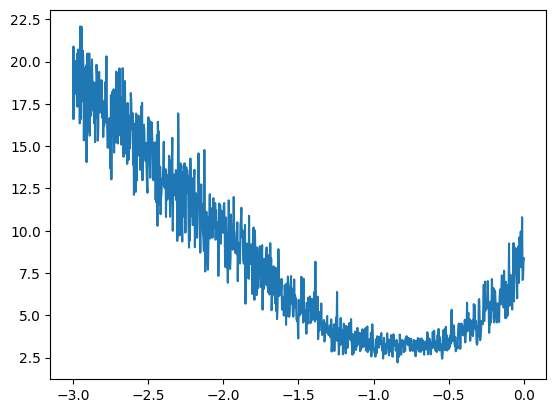

In [67]:
plt.plot(lri, lossi)

Exponent of -1 is a good estimate (lowest point of graph)

Hence, 0.1 is a good estimate of the learning rate.

In [68]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [69]:
for p in parameters:
  p.requires_grad= True

In [70]:
for i in range(10000):

  # minibatch construct
  ix = torch.randint(0, X.shape[0], (32,))

  # forward pass
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Y[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None # Corrected: set grad to None to clear it, or use p.grad.zero_()
  loss.backward()

  #update
  for p in parameters:
    p.data+= -0.1*p.grad
print(loss.item())

2.8150577545166016


**Splitting into train, val, test splits**

Train Set- for training the parameters of the model

Validation Set- for finding the best hyperparameters of the model

Test Set- for evaluating the model


In [71]:
# build the dataset
block_size = 3

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [72]:
Xtr.shape, Xdev.shape, Xte.shape

(torch.Size([182437, 3]), torch.Size([22781, 3]), torch.Size([22928, 3]))

In [113]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [114]:
for p in parameters:
  p.requires_grad= True

In [115]:
lri= []
lossi= []
stepi= []

In [116]:
for i in range(200000):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None # Corrected: set grad to None to clear it, or use p.grad.zero_()
  loss.backward()

  #update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

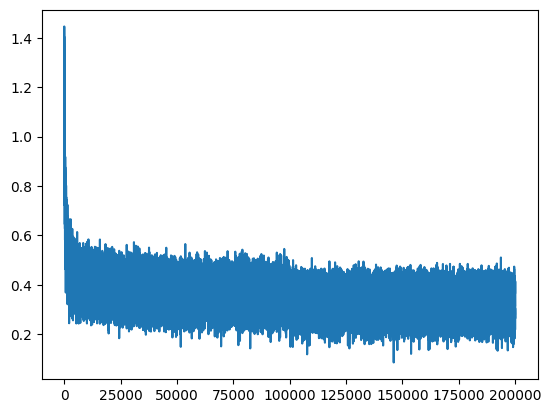

In [117]:
plt.plot(stepi, lossi)

In [118]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1420, grad_fn=<NllLossBackward0>)

In [119]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1953, grad_fn=<NllLossBackward0>)

**Sampling from the model**

In [120]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carmah.
aal.
hari.
kimri.
reh.
caspanden.
jazhutladmerynci.
geni.
nellara.
chaiiv.
kaleigh.
ham.
join.
quinn.
sulivea.
jadii.
wantho.
dearynix.
kael.
dus.
